In [28]:
import pickle
import pandas as pd
import numpy as np
from numpy import linalg
import sklearn
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia

# Load dataset

In [2]:
f = open('data/chunks.pkl', 'rb')
data = pickle.load(f)
f.close()

In [3]:
data.head()

,text,lang
0,ıwlardı juzege asırıw ushın jirobankler qurıla...,kaa
1,eksas AQSHtin qublashigisinda Atlantika okeani...,kaa
2,asina shekem Kaspiy ham Aral tenizi boylarinan...,kaa
3,rigoriy kestesinde jıldın on birinshi ayı kunn...,kaa
4,andi Ol jili martta Дорогобуж rayoni ushin bol...,kaa


In [6]:
X = data['text']
y = data['lang']

# Baseline Model
Based on https://towardsdatascience.com/an-efficient-language-detection-model-using-naive-bayes-85d02b51cfbd

Train time about 30 min

In [7]:
# set up model, vectorizer
cnt = CountVectorizer(analyzer = 'char',ngram_range=(2,2)) # bigrams
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

In [10]:
# do cross validation
skf = StratifiedKFold(n_splits=5, random_state=0)
clf = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')

In [11]:
clf

array([0.90547761, 0.90541755, 0.90622952, 0.90568368, 0.90598925])

In [1]:
# get predictions for confusion matrix
y_pred = cross_val_predict(pipeline, X, y, cv=skf)

In [56]:
# make confusion matrix
labels = sorted(y.unique().tolist())
mat = confusion_matrix(y, y_pred, normalize='true', labels=labels)

In [58]:
mat

array([[0.9924812 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.83541267, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9884    , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00162308, ..., 0.31325518, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.9661    ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.61026103]])

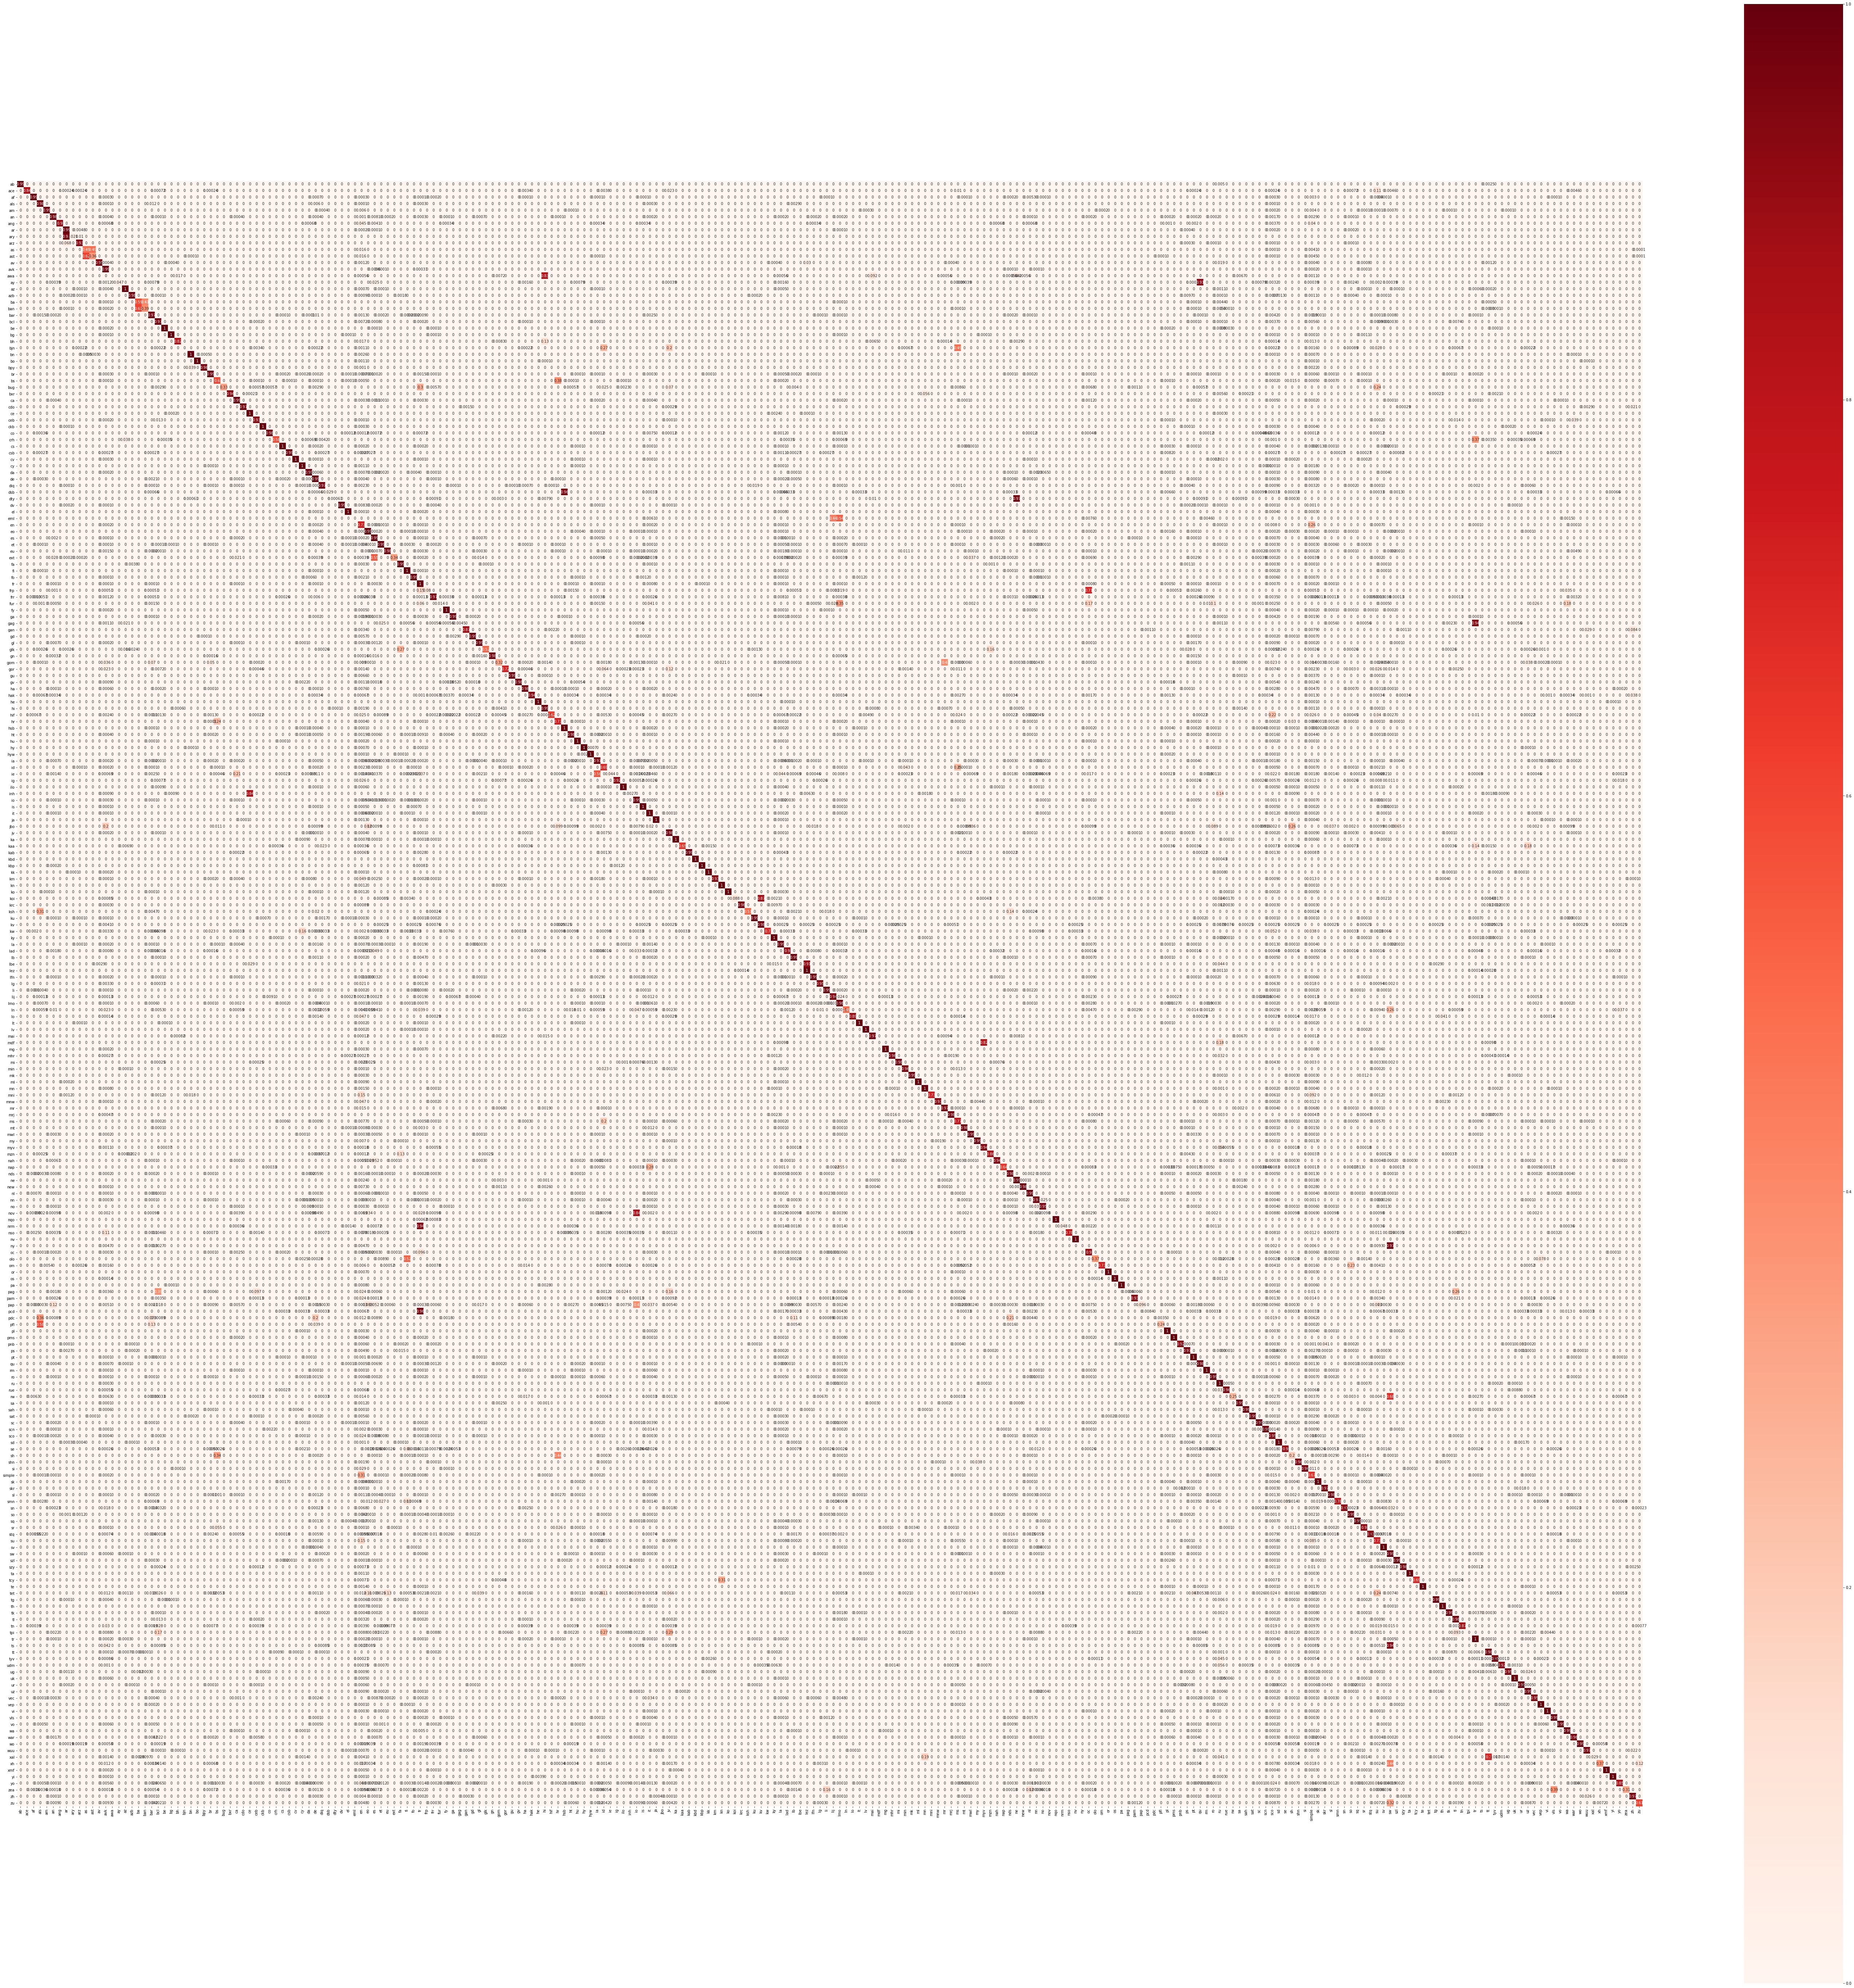

In [65]:
fig, ax = plt.subplots(figsize=(100,100))         
sns.heatmap(mat, square=True, annot=True, cmap="Reds",
           xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

# Clustering on confusion matrix
Quickly trying what Daniel Zheng did here: https://github.com/Data-Science-for-Linguists/Document_Clustering/blob/master/clustering.ipynb

In [94]:
# make the clusters
from sklearn.cluster import KMeans
num_clusters = 150

km = KMeans(n_clusters=num_clusters)

%time km.fit(mat)

clusters = km.labels_.tolist()

CPU times: user 4.07 s, sys: 29 ms, total: 4.1 s
Wall time: 516 ms


In [96]:
# figure out which cluster each language was assigned to 
cluster_titles = dict()
for cluster, title in zip(clusters, labels):
    if cluster not in cluster_titles:
        cluster_titles[cluster] = []
    cluster_titles[cluster].append(wikipedia.languages()[title])

In [97]:
# show the clusters
for cluster, titles in cluster_titles.items():
    print(cluster, ':' , ', '.join(titles), '\n')

110 : Аҧсшәа 

90 : Acèh, Ænglisc, مصرى, Boarisch, भोजपुरी, বিষ্ণুপ্রিয়া মণিপুরী, ᨅᨔ ᨕᨘᨁᨗ, буряад, qırımtatarca, English, Esperanto, euskara, furlan, 贛語, गोंयची कोंकणी / Gõychi Konknni, Bahasa Hulontalo, 客家語/Hak-kâ-ngî, Fiji Hindi, Igbo, Qaraqalpaqsha, ភាសាខ្មែរ, kernowek, Ladino, Luganda, Ligure, lingála, ລາວ, मैथिली, ꯃꯤꯇꯩ ꯂꯣꯟ, ဘာသာ မန်, Malti, Nāhuatl, Napulitano, norsk, Oromoo, Kapampangan, Papiamentu, پنجابی, Scots, davvisámegiella, Simple English, anarâškielâ, chiShona, српски / srpski, Seeltersk, Sunda, ತುಳು, tetun, Setswana, тыва дыл, удмурт, ئۇيغۇرچە / Uyghurche, vèneto, Yorùbá, Zeêuws, isiZulu 

0 : Afrikaans 

20 : Alemannisch, Ripoarisch, Deitsch, Pälzisch 

79 : አማርኛ 

112 : aragonés 

22 : العربية, الدارجة 

38 : অসমীয়া, asturianu 

149 : авар 

4 : Kotava, la .lojban., română, ślůnski 

57 : अवधी, हिन्दी 

18 : Aymar aru, Runa Simi 

62 : azərbaycanca 

67 : تۆرکجه 

32 : башҡортса, Basa Bali 

43 : Bikol Central, Cebuano, Jawa, Pangasinan, Tagalog, Tok Pisin 

59 : бел

This is great!